# Compute  PCA : Method 1 : Clustering with Mean Shift

- use PCA scikit learn from scikit learn

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/12/30
- last update : 2022/12/30

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import axes3d  

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from astroML.utils.decorators import pickle_results


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [4]:
from astropy.io import fits
import copy

In [5]:
filename = "datatools/pcamethod1_SL_eigenvectorandcoeff.fits"
hdu = fits.open(filename)

In [6]:
hdu.info()

Filename: datatools/pcamethod1_SL_eigenvectorandcoeff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (6362, 553)   float64   
  1                1 ImageHDU         8   (10, 550)   float64   
  2                1 ImageHDU         8   (6361, 10)   float64   


In [7]:
data1=hdu[0].data
hdr1 = hdu[0].header
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
EXTEND  =                    T                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

In [8]:
data2=hdu[1].data
hdr2 = hdu[1].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   10                                                  
NAXIS2  =                  550                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 spectra coefficients                                       

In [9]:
data3=hdu[2].data
hdr2 = hdu[2].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6361                                                  
NAXIS2  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 Eigen Vectors                                              

In [10]:
NSED = data1.shape[0]-3
NWL = data1.shape[1]-1

In [11]:
wavelengths = data1[0,1:] 
flambdas_average = data1[1,1:] 
flambdas_std = data1[2,1:] 
spec = data1[3:,1:] 
all_numbers = data1[3:,0] 

In [12]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_49143/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

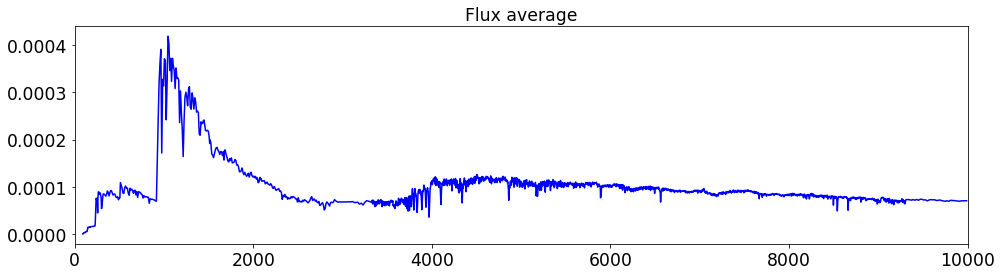

In [13]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

In [14]:
spec.shape

(550, 6361)

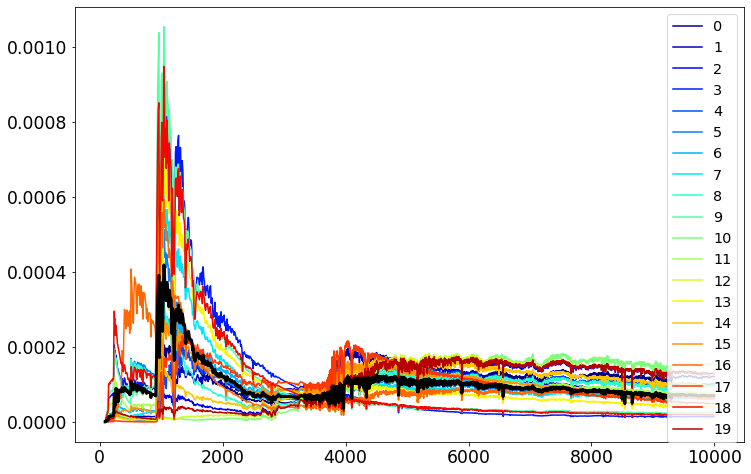

In [15]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
#plt.ylim(0,50.)

# Clustering

https://scikit-learn.org/stable/modules/clustering.html

## Clustering from PCA coefficients

In [16]:
#X = copy.deepcopy(data2[:,:5])
X = copy.deepcopy(data2)

In [17]:
X.shape

(550, 10)

In [18]:
quantile=0.05

In [19]:
bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=500)

In [20]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [21]:
print("centroids: ", ms.cluster_centers_)
print("labels: ", ms.labels_)

centroids:  [[-5.04964273e-03  8.23127328e-04 -2.66357286e-04  3.16223613e-06
  -2.97080871e-05  1.00041488e-05 -3.68512473e-05 -1.53996204e-05
  -9.25216230e-07  2.00066704e-05]
 [ 2.05674167e-03 -9.13472193e-04 -3.30994999e-04 -1.23215988e-04
  -1.20770471e-04 -1.55720093e-05  1.56349013e-05 -2.10654024e-06
   1.16777685e-05  3.44125980e-06]
 [ 3.61577970e-03 -7.63721052e-04 -6.76043492e-04 -1.99636199e-05
  -1.77072006e-04  2.28647992e-05  4.26502273e-05 -4.52055866e-06
   5.01721148e-06  1.01995263e-05]
 [-2.46821000e-03  3.04808664e-04 -2.09769632e-04 -6.13733551e-05
   1.16889022e-04 -1.63813061e-05  1.92076935e-05 -1.43333969e-05
   9.17198206e-06 -3.20874027e-05]
 [-2.35617448e-03 -8.05344605e-04  5.03392921e-04  1.67298874e-05
   2.80650722e-05  3.41110866e-05 -2.62151847e-05 -1.47545087e-05
   2.65507724e-05 -3.47764096e-05]
 [ 5.39679223e-03  8.63009136e-04  2.61071583e-07  1.04013743e-03
   4.00651680e-04 -8.97872757e-05 -6.07583376e-05 -3.00078143e-06
  -1.52467718e-05 -1.

In [22]:
mydict = {i: np.where(ms.labels_ == i)[0] for i in range(n_clusters_)}

In [23]:
mydict

{0: array([  2,  10,  12,  19,  21,  24,  57,  63,  66,  68,  69,  76,  78,
         79,  80,  84,  86,  87,  90,  94,  97, 100, 101, 105, 106, 108,
        133, 134, 137, 138, 142, 144, 145, 147, 150, 153, 155, 156, 165,
        167, 170, 179, 180, 187, 192, 194, 198, 200, 201, 220, 221, 223,
        224, 229, 233, 240, 246, 252, 254, 259, 271, 279, 280, 282, 284,
        287, 292, 294, 296, 297, 304, 317, 321, 324, 325, 326, 327, 328,
        330, 332, 333, 334, 335, 337, 340, 341, 342, 348, 349, 351, 355,
        357, 360, 364, 372, 375, 379, 384, 385, 388, 389, 393, 399, 405,
        412, 419, 422, 424, 426, 427, 434, 453, 464, 465, 477, 479, 481,
        484, 487, 488, 490, 495, 496, 499, 502, 503, 508, 513, 514, 523,
        527, 529, 531, 532, 537, 546, 549]),
 1: array([  5,   7,  13,  25,  26,  32,  34,  35,  40,  43,  47,  49,  50,
         52,  53,  54,  55,  59,  71,  72,  83,  92, 109, 114, 117, 118,
        119, 120, 125, 126, 127, 128, 132, 139, 143, 157, 158, 160, 163,


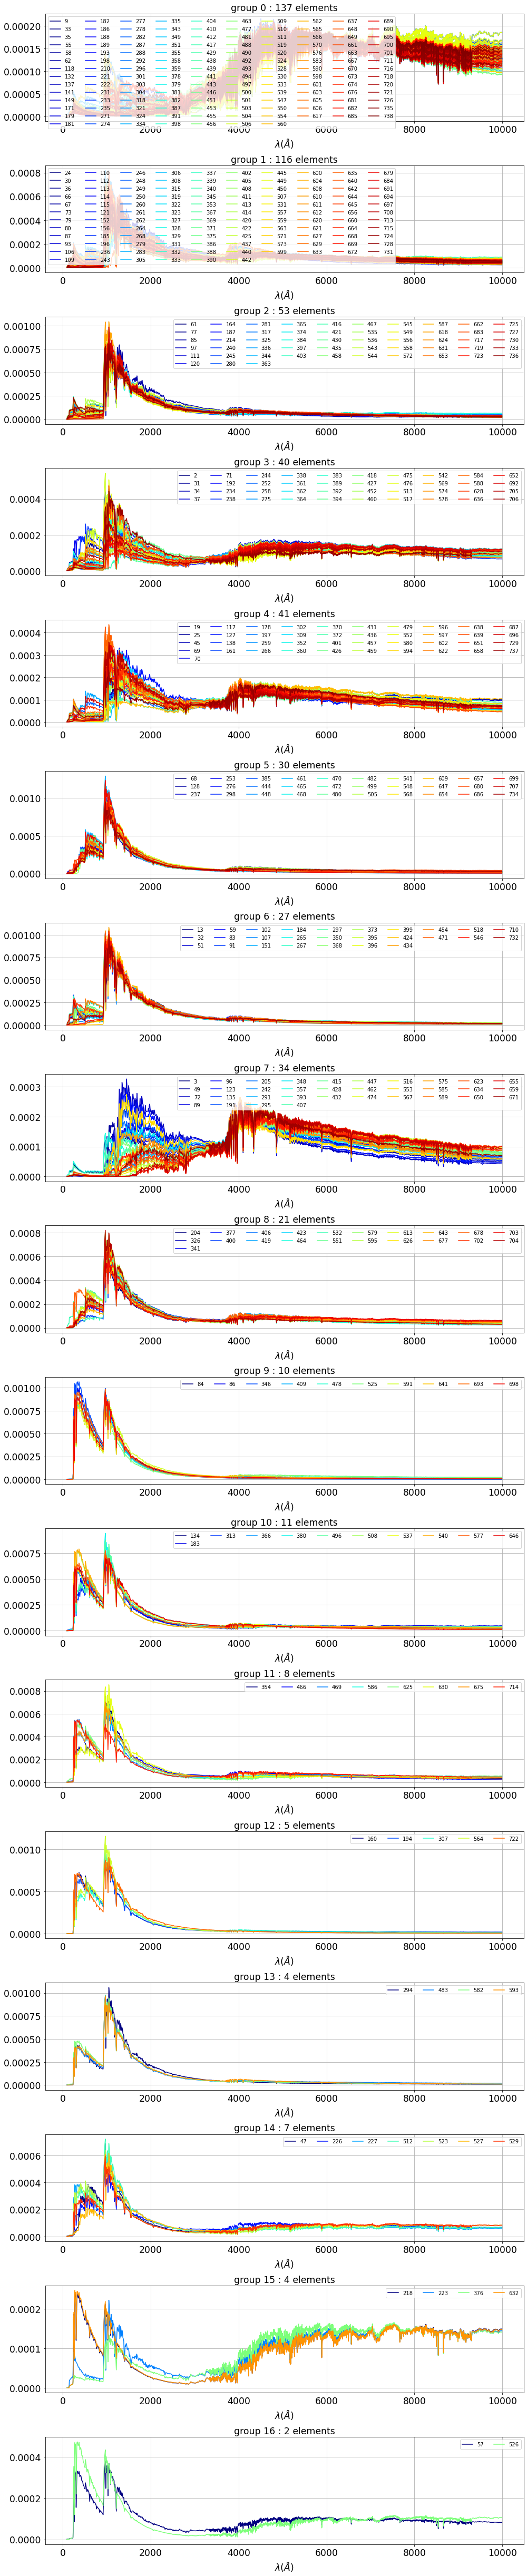

In [25]:
fig = plt.figure(figsize=(14, n_clusters_*4))

for icluster in range(n_clusters_):
    ax=fig.add_subplot(n_clusters_,1,1+icluster)
    
    the_group = mydict[icluster]

    NTOPLOT=len(the_group)
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)
    
    icount=0
    for idx in the_group:
        the_num=all_numbers[idx]
        the_label=f"{the_num:.0f}"
        ax.plot(wavelengths,spec[idx,:],color=all_colors[icount],label=the_label)
        icount+=1
    ax.set_title(f"group {icluster} : {NTOPLOT} elements")
    ax.set_xlabel("$\lambda (\AA)$ ")
    ax.legend(loc="best",ncol=10,fontsize=10)
    ax.grid()
        
        
plt.tight_layout()
    
